<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 5.1 Evolutionary Strategies

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

# <a id="es"></a>Evolutionary Strategies

Evolutionary strategies are a class of evolutionary algorithms first developed in the 1960s. These algorithms are notable for their statistical recombination of the population to inform the next generation and are most often used for continuous optimization problem. Evolutionary Strategies such as CMA-ES, which we'll discuss next, have a long history of application in a variety of domains and recently have been applied to the optimization of neural network weights.

+ I. Rechenberg and M. Eigen. Evolutionsstrategie: Optimierung Technischer Systeme nach Prinzipien der Biologischen Evolution. Frommann-Holzboog Stuttgart, 1973.
+ Wierstra, Daan, et al. "Natural evolution strategies." The Journal of Machine Learning Research 15.1 (2014): 949-980. [PDF](http://www.jmlr.org/papers/volume15/wierstra14a/wierstra14a.pdf)
+ Salimans, Tim, et al. "Evolution strategies as a scalable alternative to reinforcement learning." arXiv preprint arXiv:1703.03864 (2017).

In [1]:
using Statistics
using LinearAlgebra
using Plots
gr(reuse=true)

Plots.GRBackend()

Let's start by optimizing over a sphere function with an offset center.

In [2]:
s = [3.5, -0.2]
sphere(x::Array{Float64}) = -sum((x .- s).^2)
objective = sphere

sphere (generic function with 1 method)

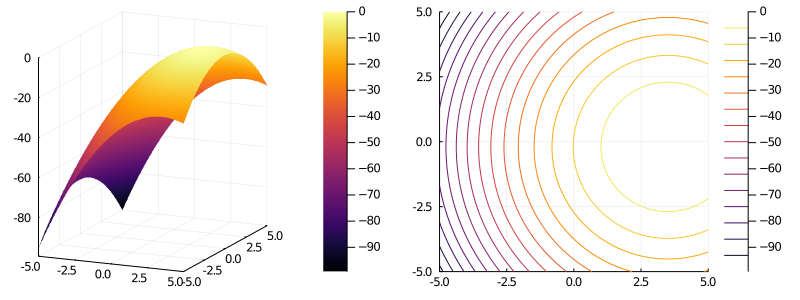

In [3]:
xs = -5:0.1:5
ys = -5:0.1:5
fz(x, y) = objective([x, y])
plot(plot(xs, ys, fz, st=:surface), plot(xs, ys, fz, st=:contour), size = (800, 300))

We'll start with a very simple example of an evolutionary strategy. In this $(1,\lambda)$ Evolutionary Strategy, we will first create random individuals around an expert with a standard deviation of $\sigma$. This is our population. Let's define some parameters

<div class="alert alert-info">
    <b>Notation: $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$</b>
    <br/>
    In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents are included for creating the next population, $(\mu/\rho,\lambda)$ means the parents are not included. We've already seen the $(1+1)$ and $(1+\lambda)$ algorithms, where the 1 parent is included in the next population based on its fitness. CMA-ES is a $(\mu/\mu_I,\lambda)$ algorithm where a transformation of $\mu$, $\mu_I$, will inform the next population.
    </div>

In [4]:
npop = 50     # population size
sigma = 0.1   # noise standard deviation
alpha = 0.001 # step size
x = randn(2)  # initial expert

2-element Array{Float64,1}:
 0.28330691092036864
 0.41477836931768425

Since we'll be staying in the continuous optimization domain today, we won't define an `Individual` class but will use matrices for our population. Let's now create the population around `x` with standard deviation $\sigma$. We will use a Normal distribution.

In [5]:
N = randn(npop, 2)
P = repeat(x, 1, npop)' .+ sigma .* N;

Now we have our population and can evaluate them. We will also normalize the evaluation $f(x)$ using $\frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

In [6]:
R = zeros(npop)
for i in eachindex(R)
    R[i] = objective(P[i, :])
end
A = (R .- mean(R)) ./ std(R);

Let's see how our population looks on our objective function. The black rectangle is our current expert.

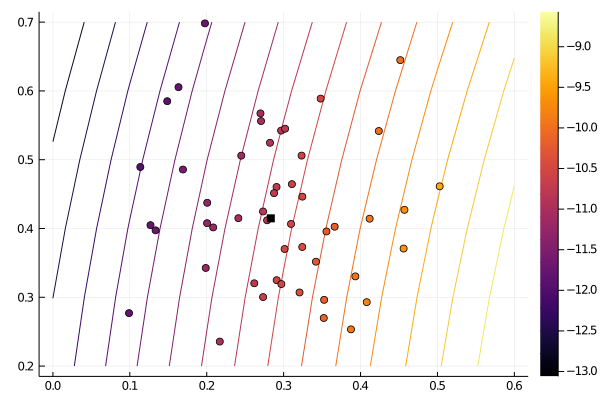

In [7]:
xs = floor(minimum(P[:,1]), digits=1):0.1:ceil(maximum(P[:,1]), digits=1)
ys = floor(minimum(P[:,2]), digits=1):0.1:ceil(maximum(P[:,2]), digits=1)
fz(x, y) = objective([x, y])
plot(xs, ys, fz, st=:contour)
scatter!(P[:, 1], P[:, 2], zcolor=R, legend=:none)
scatter!([x[1]], [x[2]], color=:black, marker=:rect)

As we can see, some individuals in our distribution are better than our current expert. We'll shift towards those individuals by multiplying each individual in $N$ by their normalized fitness $A$, then summing over all individuals. This gives us the direction of the gradient based on our population.

In [8]:
(dot(N[:, 1], A) / npop, dot(N[:, 2], A) / npop)

(0.9104719384441428, -0.31735853709703216)

Now that we know which direction to move in, we apply this step with a step size of $\alpha$. In other words, we move $\alpha$ along our approximation of the gradient.

In [9]:
println("Solution :", s)
println("x :", x)
x = x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)]
println("x`: ", x)

Solution :[3.5, -0.2]
x :[0.28330691092036864, 0.41477836931768425]
x`: [0.29241163030481004, 0.4116047839467139]


As we can see, we've moved closer to the objective. Let's plot this over multiple steps.

In [10]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0
fz(x, y) = objective([x, y]);

function step(x::Array{Float64}; npop=50, sigma=0.1, alpha=0.01, visualize=false, anim=Nothing)
    N = randn(npop, 2)
    P = repeat(x, 1, npop)' .+ sigma .* N
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :])
    end
    A = (R .- mean(R)) ./ std(R)
    
    if visualize
        plot(xs, ys, fz, st=:contour)
        scatter!(P[:, 1], P[:, 2], xlims=(-5, 5), ylims=(-5, 5), zcolor=R)
        scatter!([x[1]], [x[2]], legend=:none, color=:black, marker=:rect)
        frame(anim)
    end
    
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)]
end

step (generic function with 1 method)

In [11]:
function plot_obj()
    x = randn(2)
    println("x initial: ", x)
    anim = Animation()
    for i in 1:500
        v = mod(i, 10) == 0
        x = step(x, npop=50, sigma=0.1, alpha=0.001, visualize=v, anim=anim)
    end
    println("x final: ", x)
    gif(anim)
end

plot_obj (generic function with 1 method)

Let's also define some other objective functions just for testing.

In [12]:
himmelblau(x::Array{Float64}) = -((x[1]^2 + x[2] - 11)^2 + (x[1] + x[2]^2 - 7)^2)
styblinski_tang(x::Array{Float64}) = -(sum(x.^4 .- 16 .* x.^2 .+ 5 .* x) / 2.0)
rastrigin(x::Array{Float64}) = -(10.0 * length(x) .+ sum((x .- s).^2 .- 10 .* cos.(2*pi.*(x .- s))))

rastrigin (generic function with 1 method)

x initial: [0.9196016891056891, -0.68919973595417]
x final: [0.5230527309314714, -0.19664324728228322]


┌ Info: Saved animation to 
│   fn = /mnt/storage/Documents/EISC-217 - Algorithmes évolutionnaires/5_strategies/tmp.gif
└ @ Plots /home/alberic/.julia/packages/Plots/ZRCUN/src/animation.jl:102


Plots.AnimatedGif("/mnt/storage/Documents/EISC-217 - Algorithmes évolutionnaires/5_strategies/tmp.gif")
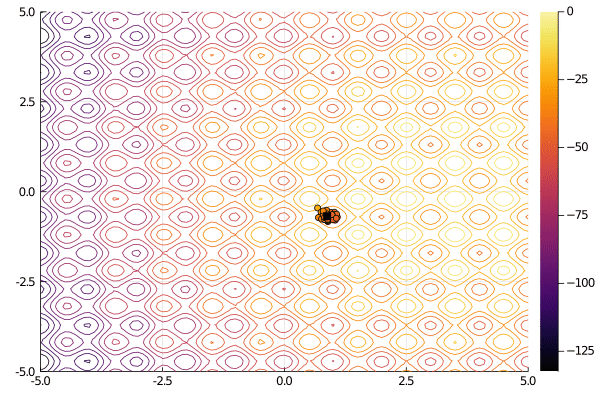

In [18]:
objective = rastrigin # sphere, himmelblau, styblinski_tang, rastrigin
plot_obj()

## <a id="edas"></a>Estimation of Distribution Algorithms

EDAs are algorithms that build a probabilistic model of candidate solutions. These are not the subject of today's lecture, but are similar and worth looking into.
    
+ Mühlenbein, Heinz, and Gerhard Paass. "From recombination of genes to the estimation of distributions I. Binary parameters." International conference on parallel problem solving from nature. Springer, Berlin, Heidelberg, 1996.
+ Larrañaga, Pedro, and Jose A. Lozano, eds. Estimation of distribution algorithms: A new tool for evolutionary computation. Vol. 2. Springer Science & Business Media, 2001.
+ Pelikan, Martin, David E. Goldberg, and Fernando G. Lobo. "A survey of optimization by building and using probabilistic models." Computational optimization and applications 21.1 (2002): 5-20.

<img src="../imgs/EDAs.png" width="60%">
Hauschild, Mark, and Martin Pelikan. "An introduction and survey of estimation of distribution algorithms." Swarm and evolutionary computation 1.3 (2011): 111-128.